<a href="https://colab.research.google.com/github/viviandonohoe/machinelearningproject/blob/main/ml_spanishnotarialdocuments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code I'm working on for optimizing OCR on Spanish notarial documents.


Loading the things:

In [29]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import os
import collections

Data stuff

In [30]:
!git clone https://github.com/viviandonohoe/DeepLearningSpanishAmericanCopy.git

fatal: destination path 'DeepLearningSpanishAmericanCopy' already exists and is not an empty directory.


In [31]:
!ls /content/DeepLearningSpanishAmericanCopy/

 CharactersDataset		   Merged	  'Updated Documentation.docx'
 Dataset			   models	   YOLO-OCR
'Image comparison Document.docx'   README.md
 Keras-OCR			   Search-Engine


In [32]:
import os

repo_path = "/content/DeepLearningSpanishAmericanCopy"
dataset_path = os.path.join(repo_path, "Dataset")
character_dataset_path = os.path.join(repo_path, "CharactersDataset")

print(os.listdir(dataset_path))
print(os.listdir(character_dataset_path))

['Training', '.DS_Store', 'Test']
['TrainingSet', 'TestSet']


In [33]:
def load_dataset(root_path, size=(32,32)):
  X = []
  y = []
  for label in sorted(os.listdir(root_path)):
    label_path = os.path.join(root_path, label)
    if not os.path.isdir(label_path):
      continue

    for filename in os.listdir(label_path):
      if filename in [".DS_Store", "__MACOSX"]:
        continue
      file_path = os.path.join(label_path, filename)
      img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
      if img is None:
        continue
      img = cv2.resize(img, size)
      img = img.flatten()
      X.append(img)
      y.append(label)
  return np.array(X), np.array(y)

In [34]:
X, y = load_dataset(character_dataset_path)
train_path = os.path.join(character_dataset_path, "TrainingSet")
test_path = os.path.join(character_dataset_path, "TestSet")

X_train, y_train = load_dataset(train_path)
X_test, y_test = load_dataset(test_path)

label_counts = collections.Counter(y_train)

labels = sorted(label_counts.keys())
counts = [label_counts[label] for label in labels]


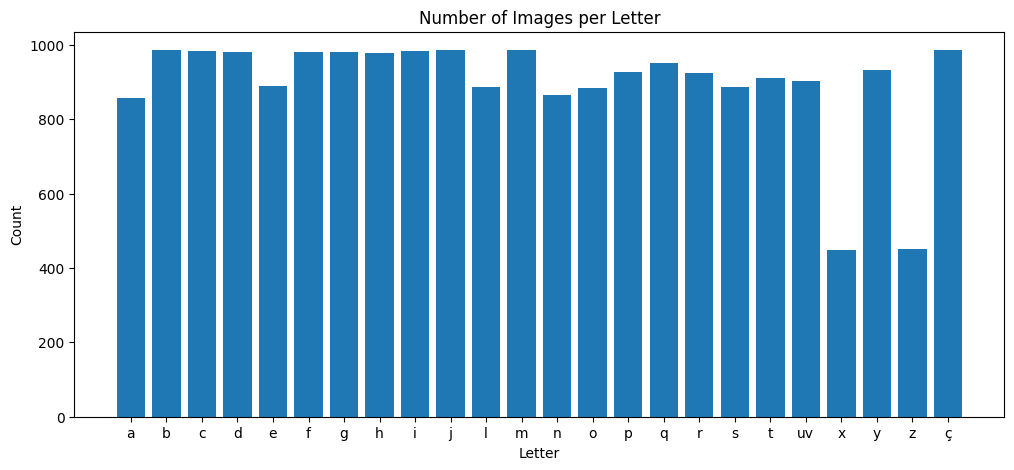

Train: (21546, 1024) Labels: (21546,)
Test: (1176, 1024) Labels: (1176,)


In [35]:
plt.figure(figsize=(12, 5))
plt.bar(labels, counts)
plt.title("Number of Images per Letter")
plt.xlabel("Letter")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


print("Train:", X_train.shape, "Labels:", y_train.shape)
print("Test:", X_test.shape, "Labels:", y_test.shape)

KNN Approach

In [36]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_knn))

Test accuracy: 0.8299319727891157


KNN Approach with added PCA Dimension Reduction

In [37]:
pca = PCA(n_components=50)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

knnwithpca = KNeighborsClassifier(n_neighbors=4)
knnwithpca.fit(X_train_PCA, y_train)

y_pred_pca = knnwithpca.predict(X_test_PCA)
print("Test accuracy (using PCA):", accuracy_score(y_test, y_pred_pca))

Test accuracy (using PCA): 0.8656462585034014


CNN Approach (using pytorch)

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm

In [51]:
class CharacterDataset(Dataset):
    def __init__(self, root_path, img_size=(32, 32), label_encoder=None):
        self.image_paths = []
        self.labels = []
        self.img_size = img_size

        for label in sorted(os.listdir(root_path)):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
            for filename in os.listdir(label_path):
                if filename in [".DS_Store", "__MACOSX"]:
                    continue
                file_path = os.path.join(label_path, filename)
                self.image_paths.append(file_path)
                self.labels.append(label)

        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)
        else:
            self.label_encoder = label_encoder

        self.encoded_labels = self.label_encoder.transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).unsqueeze(0)
        label = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return img, label

def train_and_evaluate(model, model_name, train_loader, test_loader,
                       label_encoder, device, epochs=10, lr=0.001):
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100. * correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Train Acc={train_acc:.2f}%")
    # -------- Evaluation --------
    model.eval()

    correct = 0
    total = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    model.eval()

    test_acc = 100. * correct / total
    params = sum(p.numel() for p in model.parameters())

    print(f"\n{model_name} Results:")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    print(f"  Parameters: {params:,}")

    return {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'train_accuracy': train_acc,
        'parameters': params,
        'model': model,
        'y_true': y_true,
        'y_pred': y_pred
    }

In [56]:
train_dataset = CharacterDataset(train_path)
test_dataset = CharacterDataset(test_path, label_encoder=train_dataset.label_encoder)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.label_encoder.classes_}")

shallow_cnn = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 256), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

basic_cnn = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

deep_cnn = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(256 * 2 * 2, 512), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

models = {
    'Shallow CNN (2 layers)': shallow_cnn,
    'Basic CNN (3 layers)': basic_cnn,
    'Deep CNN (4 layers)': deep_cnn
}

results = []

for name, model in models.items():
    result = train_and_evaluate(
        model, name,
        train_loader, test_loader,
        train_dataset.label_encoder, device,
        epochs=10
    )

    results.append(
        compute_metrics(
            result["y_true"],
            result["y_pred"],
            name
        )
    )


Number of classes: 24
Classes: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'uv' 'x' 'y' 'z' 'ç']

Training: Shallow CNN (2 layers)


Epoch 1: 100%|██████████| 674/674 [00:20<00:00, 33.55it/s]


Epoch 1: Loss=1.2029, Train Acc=64.04%


Epoch 2: 100%|██████████| 674/674 [00:20<00:00, 33.41it/s]


Epoch 2: Loss=0.5477, Train Acc=83.45%


Epoch 3: 100%|██████████| 674/674 [00:20<00:00, 33.38it/s]


Epoch 3: Loss=0.4075, Train Acc=87.45%


Epoch 4: 100%|██████████| 674/674 [00:20<00:00, 33.47it/s]


Epoch 4: Loss=0.3215, Train Acc=89.95%


Epoch 5: 100%|██████████| 674/674 [00:20<00:00, 33.47it/s]


Epoch 5: Loss=0.2778, Train Acc=91.25%


Epoch 6: 100%|██████████| 674/674 [00:20<00:00, 33.45it/s]


Epoch 6: Loss=0.2297, Train Acc=92.98%


Epoch 7: 100%|██████████| 674/674 [00:20<00:00, 33.54it/s]


Epoch 7: Loss=0.2043, Train Acc=93.26%


Epoch 8: 100%|██████████| 674/674 [00:20<00:00, 33.47it/s]


Epoch 8: Loss=0.1747, Train Acc=94.20%


Epoch 9: 100%|██████████| 674/674 [00:20<00:00, 33.50it/s]


Epoch 9: Loss=0.1520, Train Acc=94.91%


Epoch 10: 100%|██████████| 674/674 [00:20<00:00, 33.56it/s]


Epoch 10: Loss=0.1318, Train Acc=95.72%


Testing: 100%|██████████| 37/37 [00:00<00:00, 51.42it/s]



Shallow CNN (2 layers) Results:
  Test Accuracy: 93.20%
  Parameters: 1,073,816

Training: Basic CNN (3 layers)


Epoch 1: 100%|██████████| 674/674 [00:20<00:00, 32.90it/s]


Epoch 1: Loss=1.1906, Train Acc=63.80%


Epoch 2: 100%|██████████| 674/674 [00:20<00:00, 32.97it/s]


Epoch 2: Loss=0.4535, Train Acc=86.72%


Epoch 3: 100%|██████████| 674/674 [00:20<00:00, 32.91it/s]


Epoch 3: Loss=0.3228, Train Acc=90.58%


Epoch 4: 100%|██████████| 674/674 [00:20<00:00, 33.01it/s]


Epoch 4: Loss=0.2466, Train Acc=92.81%


Epoch 5: 100%|██████████| 674/674 [00:20<00:00, 33.09it/s]


Epoch 5: Loss=0.1964, Train Acc=93.91%


Epoch 6: 100%|██████████| 674/674 [00:20<00:00, 32.97it/s]


Epoch 6: Loss=0.1664, Train Acc=94.87%


Epoch 7: 100%|██████████| 674/674 [00:20<00:00, 32.90it/s]


Epoch 7: Loss=0.1422, Train Acc=95.51%


Epoch 8: 100%|██████████| 674/674 [00:20<00:00, 32.98it/s]


Epoch 8: Loss=0.1243, Train Acc=95.96%


Epoch 9: 100%|██████████| 674/674 [00:20<00:00, 33.13it/s]


Epoch 9: Loss=0.1067, Train Acc=96.67%


Epoch 10: 100%|██████████| 674/674 [00:20<00:00, 33.14it/s]


Epoch 10: Loss=0.0954, Train Acc=96.92%


Testing: 100%|██████████| 37/37 [00:00<00:00, 51.91it/s]



Basic CNN (3 layers) Results:
  Test Accuracy: 95.58%
  Parameters: 623,384

Training: Deep CNN (4 layers)


Epoch 1: 100%|██████████| 674/674 [00:20<00:00, 32.77it/s]


Epoch 1: Loss=1.1114, Train Acc=65.26%


Epoch 2: 100%|██████████| 674/674 [00:20<00:00, 32.76it/s]


Epoch 2: Loss=0.3747, Train Acc=88.96%


Epoch 3: 100%|██████████| 674/674 [00:20<00:00, 32.62it/s]


Epoch 3: Loss=0.2507, Train Acc=92.55%


Epoch 4: 100%|██████████| 674/674 [00:20<00:00, 32.66it/s]


Epoch 4: Loss=0.1773, Train Acc=94.73%


Epoch 5: 100%|██████████| 674/674 [00:20<00:00, 32.71it/s]


Epoch 5: Loss=0.1382, Train Acc=95.81%


Epoch 6: 100%|██████████| 674/674 [00:20<00:00, 32.66it/s]


Epoch 6: Loss=0.1040, Train Acc=96.70%


Epoch 7: 100%|██████████| 674/674 [00:20<00:00, 32.68it/s]


Epoch 7: Loss=0.0906, Train Acc=97.19%


Epoch 8: 100%|██████████| 674/674 [00:20<00:00, 32.66it/s]


Epoch 8: Loss=0.0760, Train Acc=97.63%


Epoch 9: 100%|██████████| 674/674 [00:20<00:00, 32.70it/s]


Epoch 9: Loss=0.0709, Train Acc=97.70%


Epoch 10: 100%|██████████| 674/674 [00:20<00:00, 32.59it/s]


Epoch 10: Loss=0.0557, Train Acc=98.22%


Testing: 100%|██████████| 37/37 [00:00<00:00, 52.06it/s]


Deep CNN (4 layers) Results:
  Test Accuracy: 93.62%
  Parameters: 924,952


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)


In [57]:
def compute_metrics(y_true, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [63]:

results.append(
    compute_metrics(y_test, y_pred_knn, "KNN (k=4)")
)

results.append(
    compute_metrics(y_test, y_pred_pca, "KNN + PCA (50 comps)")
)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("F1 Score", ascending=False)

results_df


,Model,Accuracy,Precision,Recall,F1 Score
1,Basic CNN (3 layers),0.955782,0.956852,0.955782,0.955799
2,Deep CNN (4 layers),0.936224,0.939971,0.936224,0.936366
0,Shallow CNN (2 layers),0.931973,0.936041,0.931973,0.931872
4,KNN + PCA (50 comps),0.865646,0.873825,0.865646,0.861734
6,KNN + PCA (50 comps),0.865646,0.873825,0.865646,0.861734
3,KNN (k=4),0.829932,0.839947,0.829932,0.823447
5,KNN (k=4),0.829932,0.839947,0.829932,0.823447


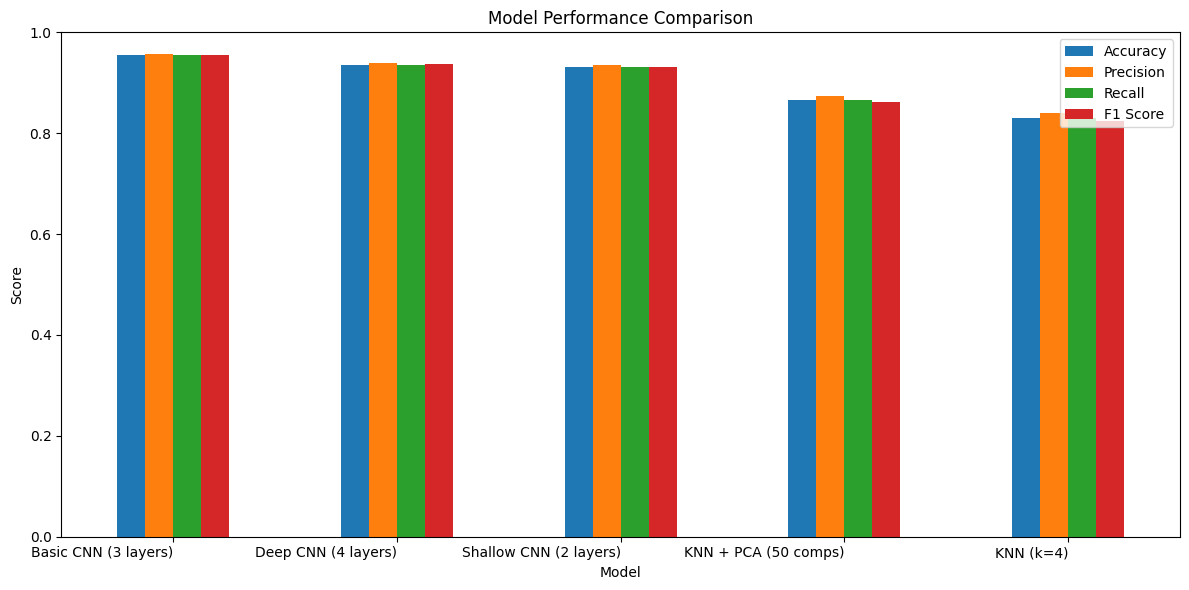

In [62]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

results_df.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(12, 6)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.show()
